# Practica 4 PIM - Arnau Vancells

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import ndimage
from scipy.misc import imresize
from scipy import signal
from skimage import filters
#LOAD IMAGES
img = Image.open("00029u.png")
#WARNING SIZE AND SHAPE INDICES ARE UPSIDE DOWN
size1_size=int(round(img.size[1]/10))
size2_size=int(round(img.size[0]/10))
img = imresize(img, ( size1_size,size2_size),interp='bilinear')
img_np = np.array(img)
x1 = 20; y1 = 20;
x2 = 25; y2 = 333;
x3 = 24; y3 = 647;
w = 336; h = 302;
im1 = img_np[y1-2:y1+h-2,x1-1:x1+w-1];
im2 = img_np[y2-2:y2+h-2,x2-1:x2+w-1];
im3 = img_np[y3-2:y3+h-2,x3-1:x3+w-1];
I1 = 255*im1.astype('double')/im1.max();
I2 = 255*im2.astype('double')/im2.max();
I3 = 255*im3.astype('double')/im3.max();
RGB=np.zeros([h,w,3],dtype=type(img_np[0,0]))
RGB[:,:,0]=I3
RGB[:,:,1]=I2
RGB[:,:,2]=I1

In [3]:
def roll(img,dispX,dispY):
    
    copyX = img[:,0:-dispX]
    img = np.concatenate((img[:,-dispX:img.shape[1]],copyX),axis=1)
    
    copyY = img[0:-dispY,:]
    img2 = np.concatenate((img[-dispY:img.shape[0],:],copyY),axis=0)
    
    return img2

In [4]:
def cross_corr(image_og, image, x, y, size, step, title=""):
    # Generate image patches
    image_og_patch = image_og[y-size:y+size+1,x-size:x+size+1]
    image_patch = image[y-size-step:y+size+step+1,x-size-step:x+size+step+1]  
    
    # Normalize patches
    image_og_patch = image_og_patch.copy()    
    image_og_patch -= image_og_patch.min()
    image_og_patch = image_og_patch / image_og_patch.max()
    image_og_patch -= image_og_patch.mean()
    
    image_patch = image_patch.copy()    
    image_patch -= image_patch.min()
    image_patch = image_patch / image_patch.max()
    image_patch -= image_patch.mean()    
    
    # Apply correlation between patches
    NCC=signal.correlate2d(image_patch.astype('float'), image_og_patch.astype('float'), mode='full', boundary='fill', fillvalue=0)
    
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Original image patch")
    plt.imshow(image_og_patch, cmap='jet')
    plt.subplot(132)
    plt.title("Displaced image patch " + title)
    plt.imshow(image_patch, cmap='jet')
    plt.subplot(133)
    plt.title("Correlation between original and displaced")
    plt.imshow(NCC, cmap='jet')
    
    print(title)
    print("---------------")
    
    # Get max. correlation position
    y_anchor, x_anchor = np.unravel_index(np.argmax(NCC), NCC.shape)
    print("Centre corr: ",x_anchor, y_anchor)
    
    # Get center of original patch
    y_og, x_og = (NCC.shape[0]//2, NCC.shape[1]//2)
    print("Centre: ",x_og, y_og)
    # Calculate distance between correlation coords and center
    dist_x , dist_y = (x_og-x_anchor, y_og-y_anchor)
    print("Distància x:",dist_x, "\nDistància y: ", dist_y, "\n")
    # Generate corrected image
    img_rolled = roll(image, dist_x, dist_y)
    return img_rolled

## Part 1

En aquesta pràctica alinearem els canals de color d'una imatge, fent servir correlacions.
La intenció és aconseguir ajuntar un canal de color que s'ha desplaçat.

El procés consistirà en:
- Obtenir el "patch" de la imatge original a buscar, i el "patch" de cerca de la imatge desplaçada.
- Fer la correlació entre les dues imatges.
- Trobar el punt de màxima correlació.
- Calcular la distància del punt central de la original i el de correlació, i aplicar el desplaçament corresponent.

Green Channel
---------------
Centre corr:  33 33
Centre:  33 33
Distància x: 0 
Distància y:  0 

Blue Channel
---------------
Centre corr:  39 30
Centre:  33 33
Distància x: -6 
Distància y:  3 



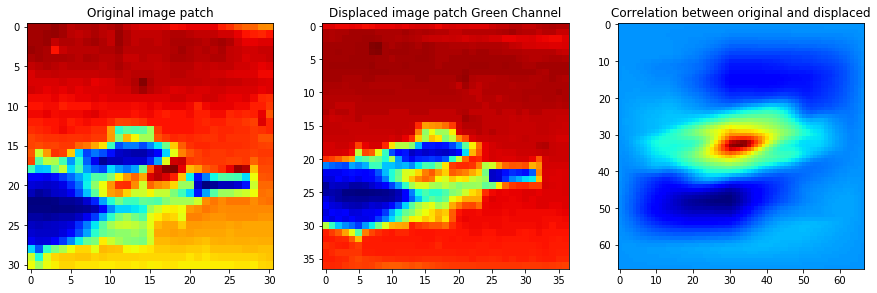

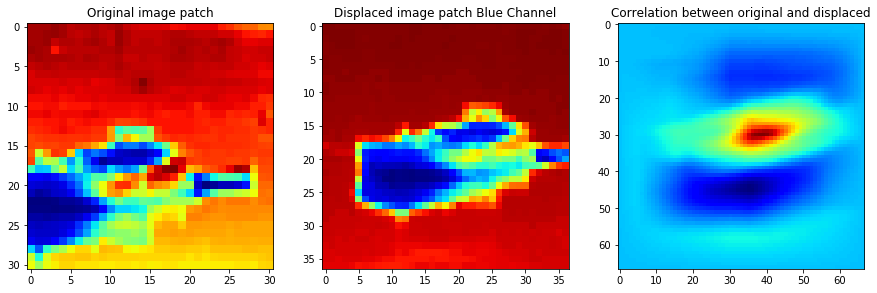

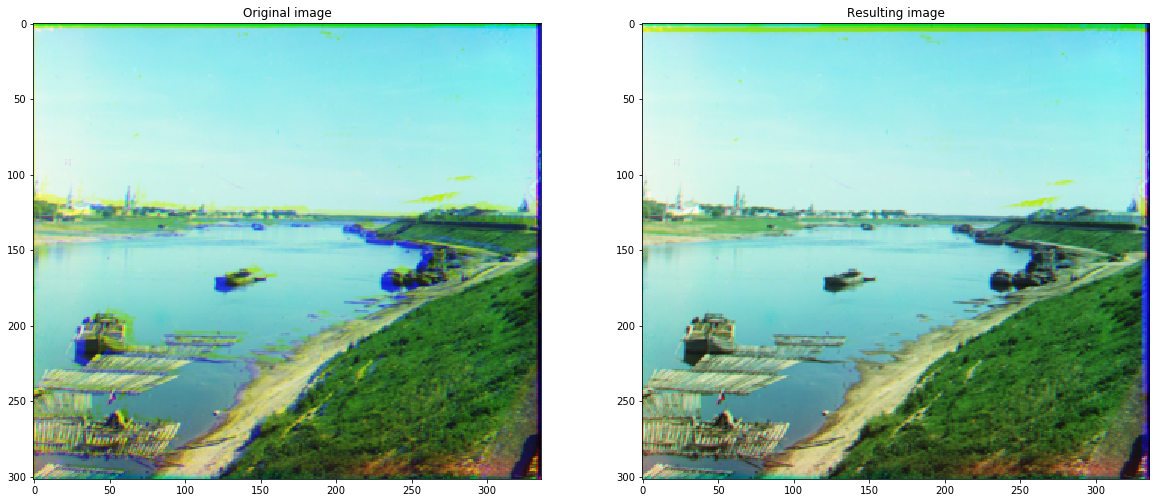

In [5]:
x = 140
y = 165
size=15
step=3

rolled_green = cross_corr(RGB[:,:,0], RGB[:,:,1], x, y, size, step, title= "Green Channel")
rolled_blue = cross_corr(RGB[:,:,0], RGB[:,:,2], x, y, size, step, title= "Blue Channel")


RGB_rolled=np.zeros([h,w,3],dtype=type(img_np[0,0]))
RGB_rolled[:,:,0]= RGB[:,:, 0]
RGB_rolled[:,:,1]= rolled_green
RGB_rolled[:,:,2]= rolled_blue

plt.figure(figsize = (20,20))
plt.subplot(121)
plt.title("Original image")
plt.imshow(RGB)
plt.subplot(122)
plt.title("Resulting image")
plt.imshow(RGB_rolled)

## Part 2
Ara, utilitzarem **la mateixa tècnica**, però en una imatge amb **molt més desplaçament.**

In [6]:
RGB_dist = RGB_rolled.copy()
RGB_dist[:,:,0] = roll(RGB_dist[:,:,0], 55, -15)

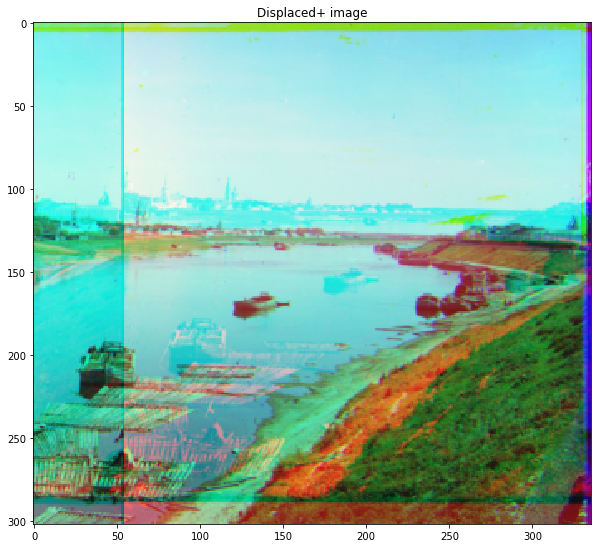

In [7]:
plt.figure(figsize=(10,10))
plt.title("Displaced+ image")
plt.imshow(RGB_dist)

Si fem servir **les mateixes mides de les finestres** utilitzades anteriorment, **no aconseguirem fer el desplaçament** correctament, ja que ara la separació és molt més gran.

Red Channel
---------------
Centre corr:  43 40
Centre:  33 33
Distància x: -10 
Distància y:  -7 

Wall time: 235 ms


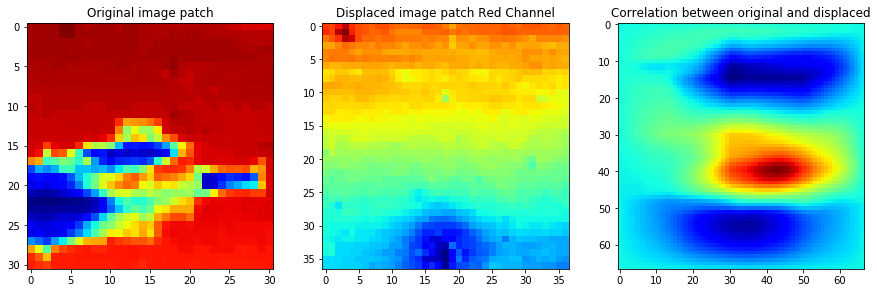

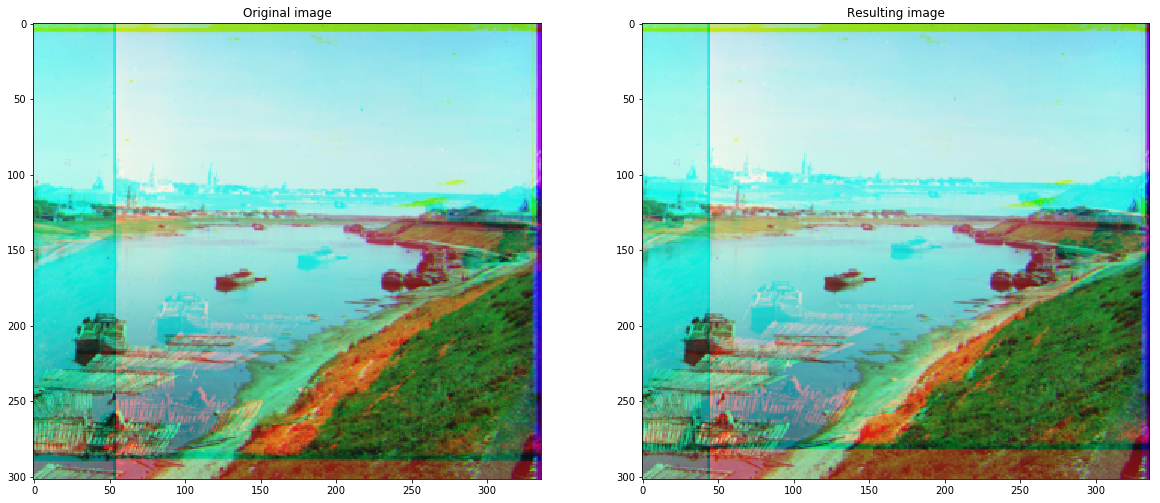

In [8]:
%%time
x = 140
y = 165
size=15
step=3

rolled_red = cross_corr(RGB_dist[:,:,1], RGB_dist[:,:,0], x, y, size, step, "Red Channel")

RGB_test=np.zeros([h,w,3],dtype=type(img_np[0,0]))
RGB_test[:,:,0]= rolled_red
RGB_test[:,:,1]= RGB_dist[:,:, 1]
RGB_test[:,:,2]= RGB_dist[:,:, 2]

plt.figure(figsize = (20,20))
plt.subplot(121)
plt.title("Original image")
plt.imshow(RGB_dist)
plt.subplot(122)
plt.title("Resulting image")
plt.imshow(RGB_test)

El que es pot fer, és **augmentar la mida de la finestra de búsqueda**, tot i que **augmentarà el cost computacional** de forma dràstica.

Red Channel big patch
---------------
Centre corr:  177 108
Centre:  123 123
Distància x: -54 
Distància y:  15 

Wall time: 2.1 s


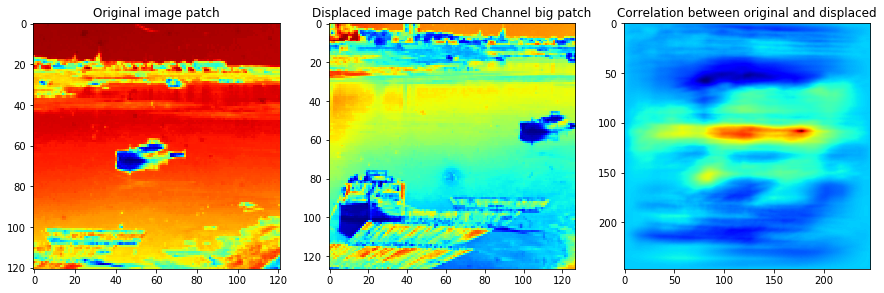

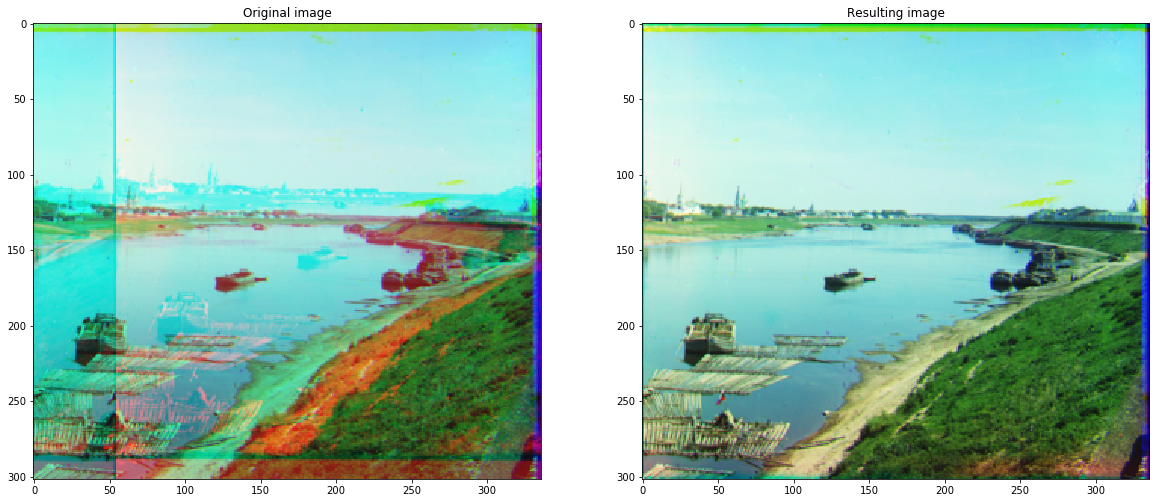

In [9]:
%%time
x = 140
y = 165
size=60
step=3

rolled_red = cross_corr(RGB_dist[:,:,1], RGB_dist[:,:,0], x, y, size, step, title="Red Channel big patch")

RGB_test=np.zeros([h,w,3],dtype=type(img_np[0,0]))
RGB_test[:,:,0]= rolled_red
RGB_test[:,:,1]= RGB_dist[:,:, 1]
RGB_test[:,:,2]= RGB_dist[:,:, 2]

plt.figure(figsize = (20,20))
plt.subplot(121)
plt.title("Original image")
plt.imshow(RGB_dist)
plt.subplot(122)
plt.title("Resulting image")
plt.imshow(RGB_test)

Com es pot observar, la imatge s'ha desplaçat correctament, però **el temps d'execució ha passat de 60ms a 1.8s, un augment del 3000% en velocitat.**

Per a solucionar aquest problema es pot fer servir la tècnica de la descomposició piramidal. Donada una n, primer realitzarem una búsqueda sobre una àrea gran del patró, aplicada sobre una imatge amb subsampling de n. Així, podrem aplicar un despleament que no té perquè ser massa precís, per a llavors fer una búsqueda sense subsampling en una àrea més petita.

El procés consistirà en:
- Obtenir el "patch" de la imatge original a buscar, i el "patch" de cerca de la imatge desplaçada fent servir una finestra més gran.
- Aplicar un filtre gaussià com a Anti-aliasing als patches.
- Aplicar sampling reduïnt la mesura dels patches.
- Fer la correlació entre els dos patches.
- Trobar el punt de màxima correlació.
- Calcular la distància del punt central de la original i el de correlació, i aplicar el desplaçament corresponent.
- Utilitzar la imatge resultant, que haurà acostat el canal desplaçat suficientment, per a aplicar el mateix procés que a la part 1.


In [14]:
def cross_corr_sampling(image_og, image, x, y, size, step, n, size_big, step_big, title=""):
    # Generate image patches
    image_og_patch_big = image_og[y-size-step:y+size+step+1,x-size-step:x+size+step+1]  
    image_patch_big = image[y-size_big-step_big:y+size_big+step_big+1,x-size_big-step_big:x+size_big+step_big+1]  
    
    # Normalize patches
    image_og_patch_big = image_og_patch_big.copy()    
    image_og_patch_big -= image_og_patch_big.min()
    image_og_patch_big = image_og_patch_big / image_og_patch_big.max()
    image_og_patch_big -= image_og_patch_big.mean()
    
    # Normalize patches
    image_patch_big = image_patch_big.copy()    
    image_patch_big -= image_patch_big.min()
    image_patch_big = image_patch_big / image_patch_big.max()
    image_patch_big -= image_patch_big.mean()
    
    # Apply gaussian filter
    image_og_patch_big_filtered = filters.gaussian(image_og_patch_big, 1)
    image_patch_big_filtered = filters.gaussian(image_patch_big, 1)
    
    # Apply sampling
    image_og_sample = image_og_patch_big_filtered[::n,::n]
    image_sample = image_patch_big_filtered[::n,::n]
    
    # Apply correlation between patches
    NCC_sample = signal.correlate2d(image_sample.astype('float'), image_og_sample.astype('float'), mode='full', boundary='fill', fillvalue=0)
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Original image big patch")
    plt.imshow(image_og_patch_big, cmap='jet')
    plt.subplot(132)
    plt.title("Displaced image patch " + title)
    plt.imshow(image_patch_big, cmap='jet')
    plt.subplot(133)
    plt.title("Correlation between original and displaced")
    plt.imshow(NCC_sample, cmap='jet')
    
    print(title)
    print("---------------")
    
    # Get max. correlation position
    y_anchor_sample, x_anchor_sample = np.unravel_index(np.argmax(NCC_sample), NCC_sample.shape)
    print("Centre corr sample big: ",x_anchor_sample, y_anchor_sample)
    
    # Get center of original patch
    y_og_sample, x_og_sample = (NCC_sample.shape[0]//2, NCC_sample.shape[1]//2)
    print("Centre sample big: ",x_og_sample, y_og_sample)
    
    # Calculate distance between correlation coords and center
    dist_x_sample , dist_y_sample = (x_og_sample-x_anchor_sample, y_og_sample-y_anchor_sample)
    print("Distància x big:",dist_x_sample, "\nDistància y big: ", dist_y_sample, "\n")
    
    # Generate corrected image aproximation
    image = roll(image, dist_x_sample*n, dist_y_sample*n)
    
    # Search image pattern(small search)   
    # Generate image patches
    image_og_patch = image_og[y-size:y+size+1,x-size:x+size+1]
    image_patch = image[y-size-step:y+size+step+1,x-size-step:x+size+step+1]  
    
    # Normalize patches
    image_og_patch = image_og_patch.copy()    
    image_og_patch -= image_og_patch.min()
    image_og_patch = image_og_patch / image_og_patch.max()
    image_og_patch -= image_og_patch.mean()
    
    # Normalize patches
    image_patch = image_patch.copy()    
    image_patch -= image_patch.min()
    image_patch = image_patch / image_patch.max()
    image_patch -= image_patch.mean()    
    
    # Apply correlation between patches
    NCC=signal.correlate2d(image_patch.astype('float'), image_og_patch.astype('float'), mode='full', boundary='fill', fillvalue=0)
    
    
        
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Original image patch")
    plt.imshow(image_og_patch, cmap='jet')
    plt.subplot(132)
    plt.title("Displaced image patch " + title)
    plt.imshow(image_patch, cmap='jet')
    plt.subplot(133)
    plt.title("Correlation between original and displaced")
    plt.imshow(NCC, cmap='jet')
    
    # Get max. correlation position
    y_anchor, x_anchor = np.unravel_index(np.argmax(NCC), NCC.shape)
    print("Centre corr: ",x_anchor, y_anchor)
    
    # Get center of original patch
    y_og, x_og = (NCC.shape[0]//2, NCC.shape[1]//2)
    print("Centre: ",x_og, y_og)
    
    # Calculate distance between correlation coords and center
    dist_x , dist_y = (x_og-x_anchor, y_og-y_anchor)
    print(dist_x, dist_y)
    
    # Generate corrected image aproximation
    img_rolled = roll(image, dist_x, dist_y)
    return img_rolled

Ara doncs, aplicarem aquesta tècnica fent servir subsampling a 2, utilitzant el filtre gaussià de sklearn amb sigma=1, que s'adaptarà a la mida de la imatge.


---------------
Centre corr sample big:  67 33
Centre sample big:  41 41
Distància x big: -26 
Distància y big:  8 

Centre corr:  35 34
Centre:  33 33
-2 -1
Wall time: 310 ms


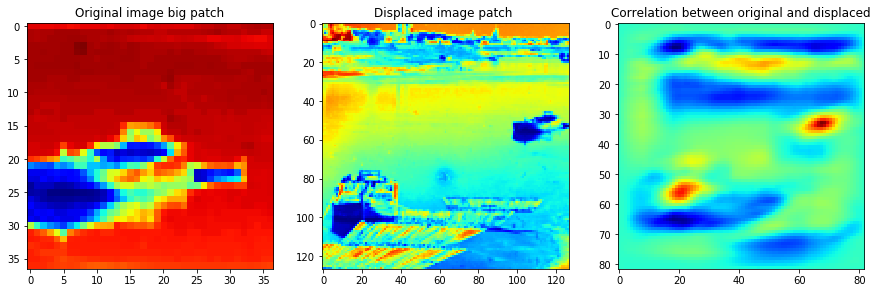

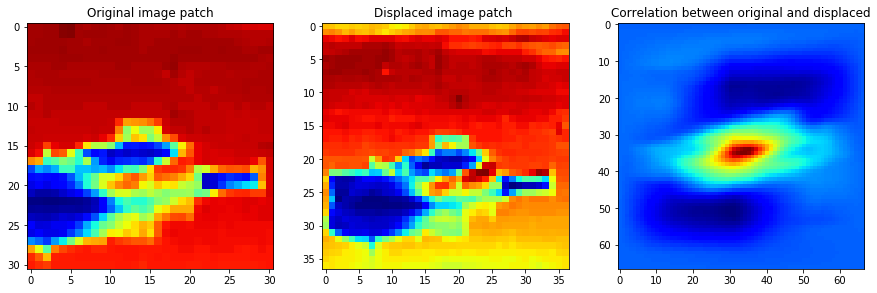

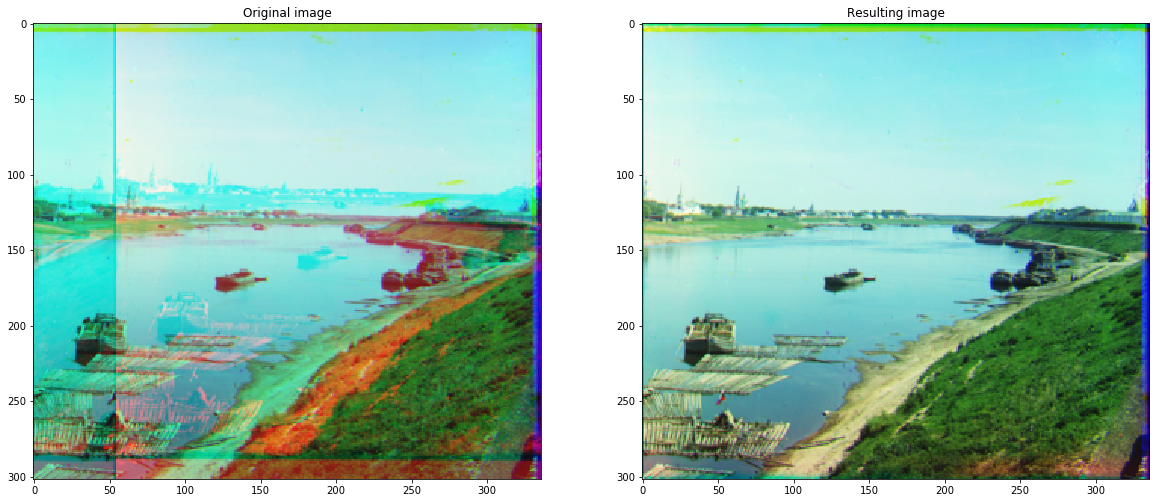

In [11]:
%%time
x = 140
y = 165
size=15
step=3
size_big=60
step_big=3
n=2

rolled_red_sample = cross_corr_sampling(RGB_dist[:,:,1], RGB_dist[:,:,0], x, y, size, step, n, size_big, step_big)

RGB_sample=np.zeros([h,w,3],dtype=type(img_np[0,0]))
RGB_sample[:,:,0]= rolled_red_sample
RGB_sample[:,:,1]= RGB_dist[:,:, 1]
RGB_sample[:,:,2]= RGB_dist[:,:, 2]

plt.figure(figsize = (20,20))
plt.subplot(121)
plt.title("Original image")
plt.imshow(RGB_dist)
plt.subplot(122)
plt.title("Resulting image")
plt.imshow(RGB_sample)

Com es pot veure, hi ha un gran canvi en el temps d'execució, ja que **hem passat de 1.8s a uns 125ms**. Per tant, fer servir sampling proporciona un **increment d'eficiència del 1440%**

Aíxi, aconseguim fer un desplaçament en un rang major, tot i que empitjorant l'eficiència en un 50% aprox.

Cal remarcar però, que els temps d'execució variaràn depenent de l'ordinador en el que s'ha executat, però l'augment d'eficiència ha de ser notable igualment.

## Part 3

Es pot aplicar un balanceig de color en la imatge resultant, per tal d'obtenir millor aspecte visual.

El balanceig de blancs es pot aplicar agafant els valor màxim de la imatge com a referència per a "desplaçar" l'histograma de tota la imatge, movent aquesta referència al valor 255, que correspòn al blanc. Així, farem que el pixel més proper a blanc sigui realment blanc.

In [34]:
from skimage import color
RGB_sample_gray = color.rgb2gray(RGB_sample)
max_white_y, max_white_x = np.unravel_index(np.argmax(RGB_sample_gray), RGB_sample_gray.shape)

RGB_white = RGB_sample.copy()
k = 255

RGB_white[0] = RGB_sample[0] * (k / RGB_sample[max_white_y, max_white_x, 0])
RGB_white[1] = RGB_sample[0] * (k / RGB_sample[max_white_y, max_white_x, 1])
RGB_white[2] = RGB_sample[0] * (k / RGB_sample[max_white_y, max_white_x, 2])


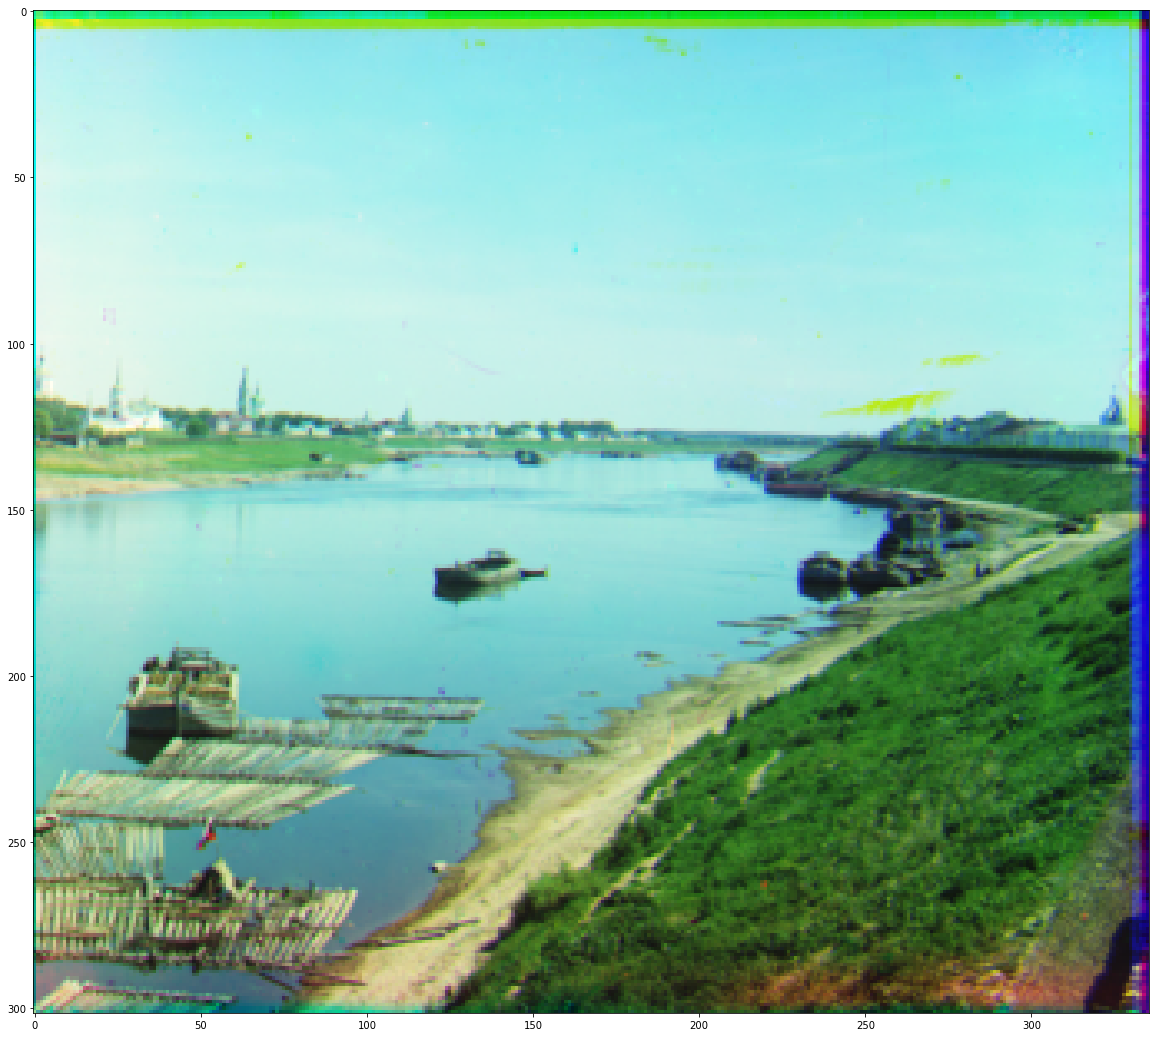

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(RGB_white)

També es poden utilizar llibreries, com és exposure de skimage, que ens proporcionen diverses funcions per a modificar les intensitats de les imatges.

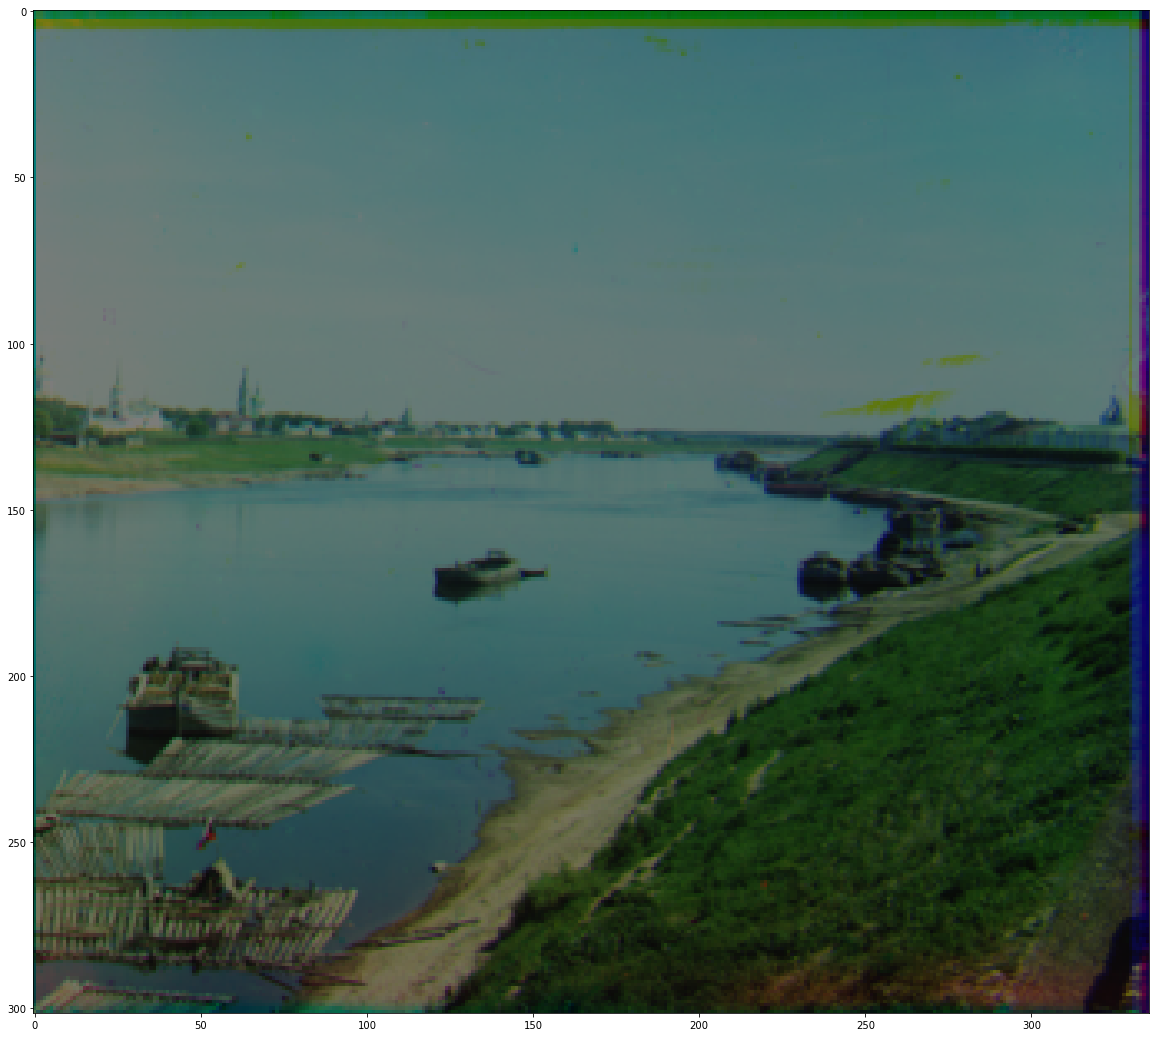

In [56]:
from skimage import exposure

# Exemple de reescalament d'intensitat, "apagant" la intentsitat de la imatge
plt.figure(figsize=(20,20))
plt.imshow(exposure.rescale_intensity(RGB_white, (0,500)))

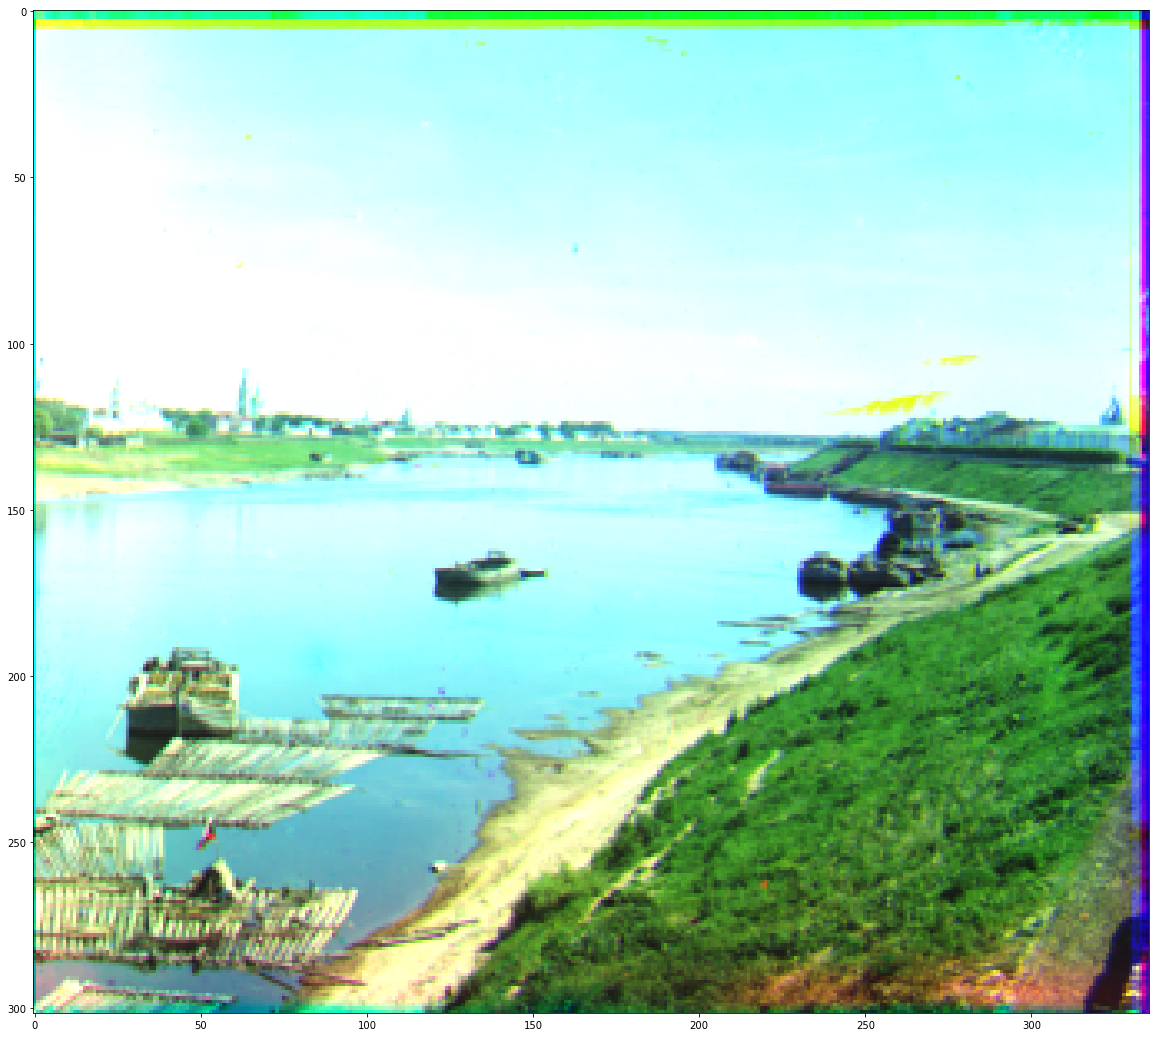

In [57]:
# Exemple de reescalament d'intensitat, "apujant" la intentsitat de la imatge
plt.figure(figsize=(20,20))
plt.imshow(exposure.rescale_intensity(RGB_white, (0,200)))